In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

In [2]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 25.
"""
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = single_template
low-frequency-cutoff = 25.



In [3]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True)
    data_filenames[ifo] = fname

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd

Processing H1 data
Processing V1 data
Processing L1 data


In [4]:
data_config = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 15
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN
""".format(event_tc=Merger("GW170817").time,
           h1file=data_filenames['H1'],
           l1file=data_filenames['L1'],
           v1file=data_filenames['V1'])
!echo '{data_config}' > data.ini
!cat data.ini


[data]
instruments = H1 L1 V1
trigger-time = 1187008882.4
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 15
pad-data = 8
sample-rate = 2048
frame-files = H1:/root/.astropy/cache/download/url/c484b43c2c76aaf6fca1a057f4d6ed52/contents L1:/root/.astropy/cache/download/url/9bb63179cc5cca254380aeb2ee25fd0d/contents V1:/root/.astropy/cache/download/url/51cfa540d575027e191b029fedbda5db/contents
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN



In [5]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =
ra =
dec =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
distance =
inclination =
delta_tc =
ra =
dec =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [6]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 2000
niterations = 200
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior
"""
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini



[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 2000
niterations = 200
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior



In [7]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference.hdf \
    --seed 28572013 \
    --nprocesses 2\
    --force

2021-12-05 18:40:47,255 Using seed 28572013
2021-12-05 18:40:47,255 Running with CPU support: 1 threads
2021-12-05 18:40:47,255 Reading configuration file
2021-12-05 18:40:47,257 Setting up model
2021-12-05 18:40:47,259 Setting up priors for each parameter
2021-12-05 18:40:47,260 No sampling_params section read from config file
2021-12-05 18:40:47,260 Loading waveform transforms
2021-12-05 18:40:47,263 Determining analysis times to use
2021-12-05 18:40:47,263 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-05 18:40:47,263 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-05 18:40:47,263 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-05 18:40:47,264 Reading Frames
2021-12-05 18:40:55,528 Highpass Filtering
2021-12-05 18:40:55,616 Resampling data
2021-12-05 1

In [8]:
!ls -lh inference.hdf

-rw-r--r-- 1 root root 309M Dec  5 18:50 inference.hdf


In [9]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr

2021-12-05 18:50:45,400 Reading input file inference.hdf
2021-12-05 18:50:45,402 Loading samples
2021-12-05 18:50:45,411 Loaded 2000 samples
2021-12-05 18:50:45,411 Getting samples for colorbar
2021-12-05 18:50:45,416 Plotting
2021-12-05 18:50:48,840 Done


In [10]:
!pycbc_inference_plot_posterior --verbose \
        --input-file inference.hdf \
        --output-file posterior-normal2d.png \
        --plot-scatter \
        --plot-contours \
        --plot-marginal \
        --z-arg 'loglikelihood:$\log p(h|\vartheta)$' \
        --iteration -1

2021-12-05 18:50:51,468 Reading input file inference.hdf
2021-12-05 18:50:51,469 Loading samples
2021-12-05 18:50:51,478 Loaded 2000 samples
2021-12-05 18:50:51,478 Getting samples for colorbar
2021-12-05 18:50:51,482 Plotting
2021-12-05 18:51:05,430 Done


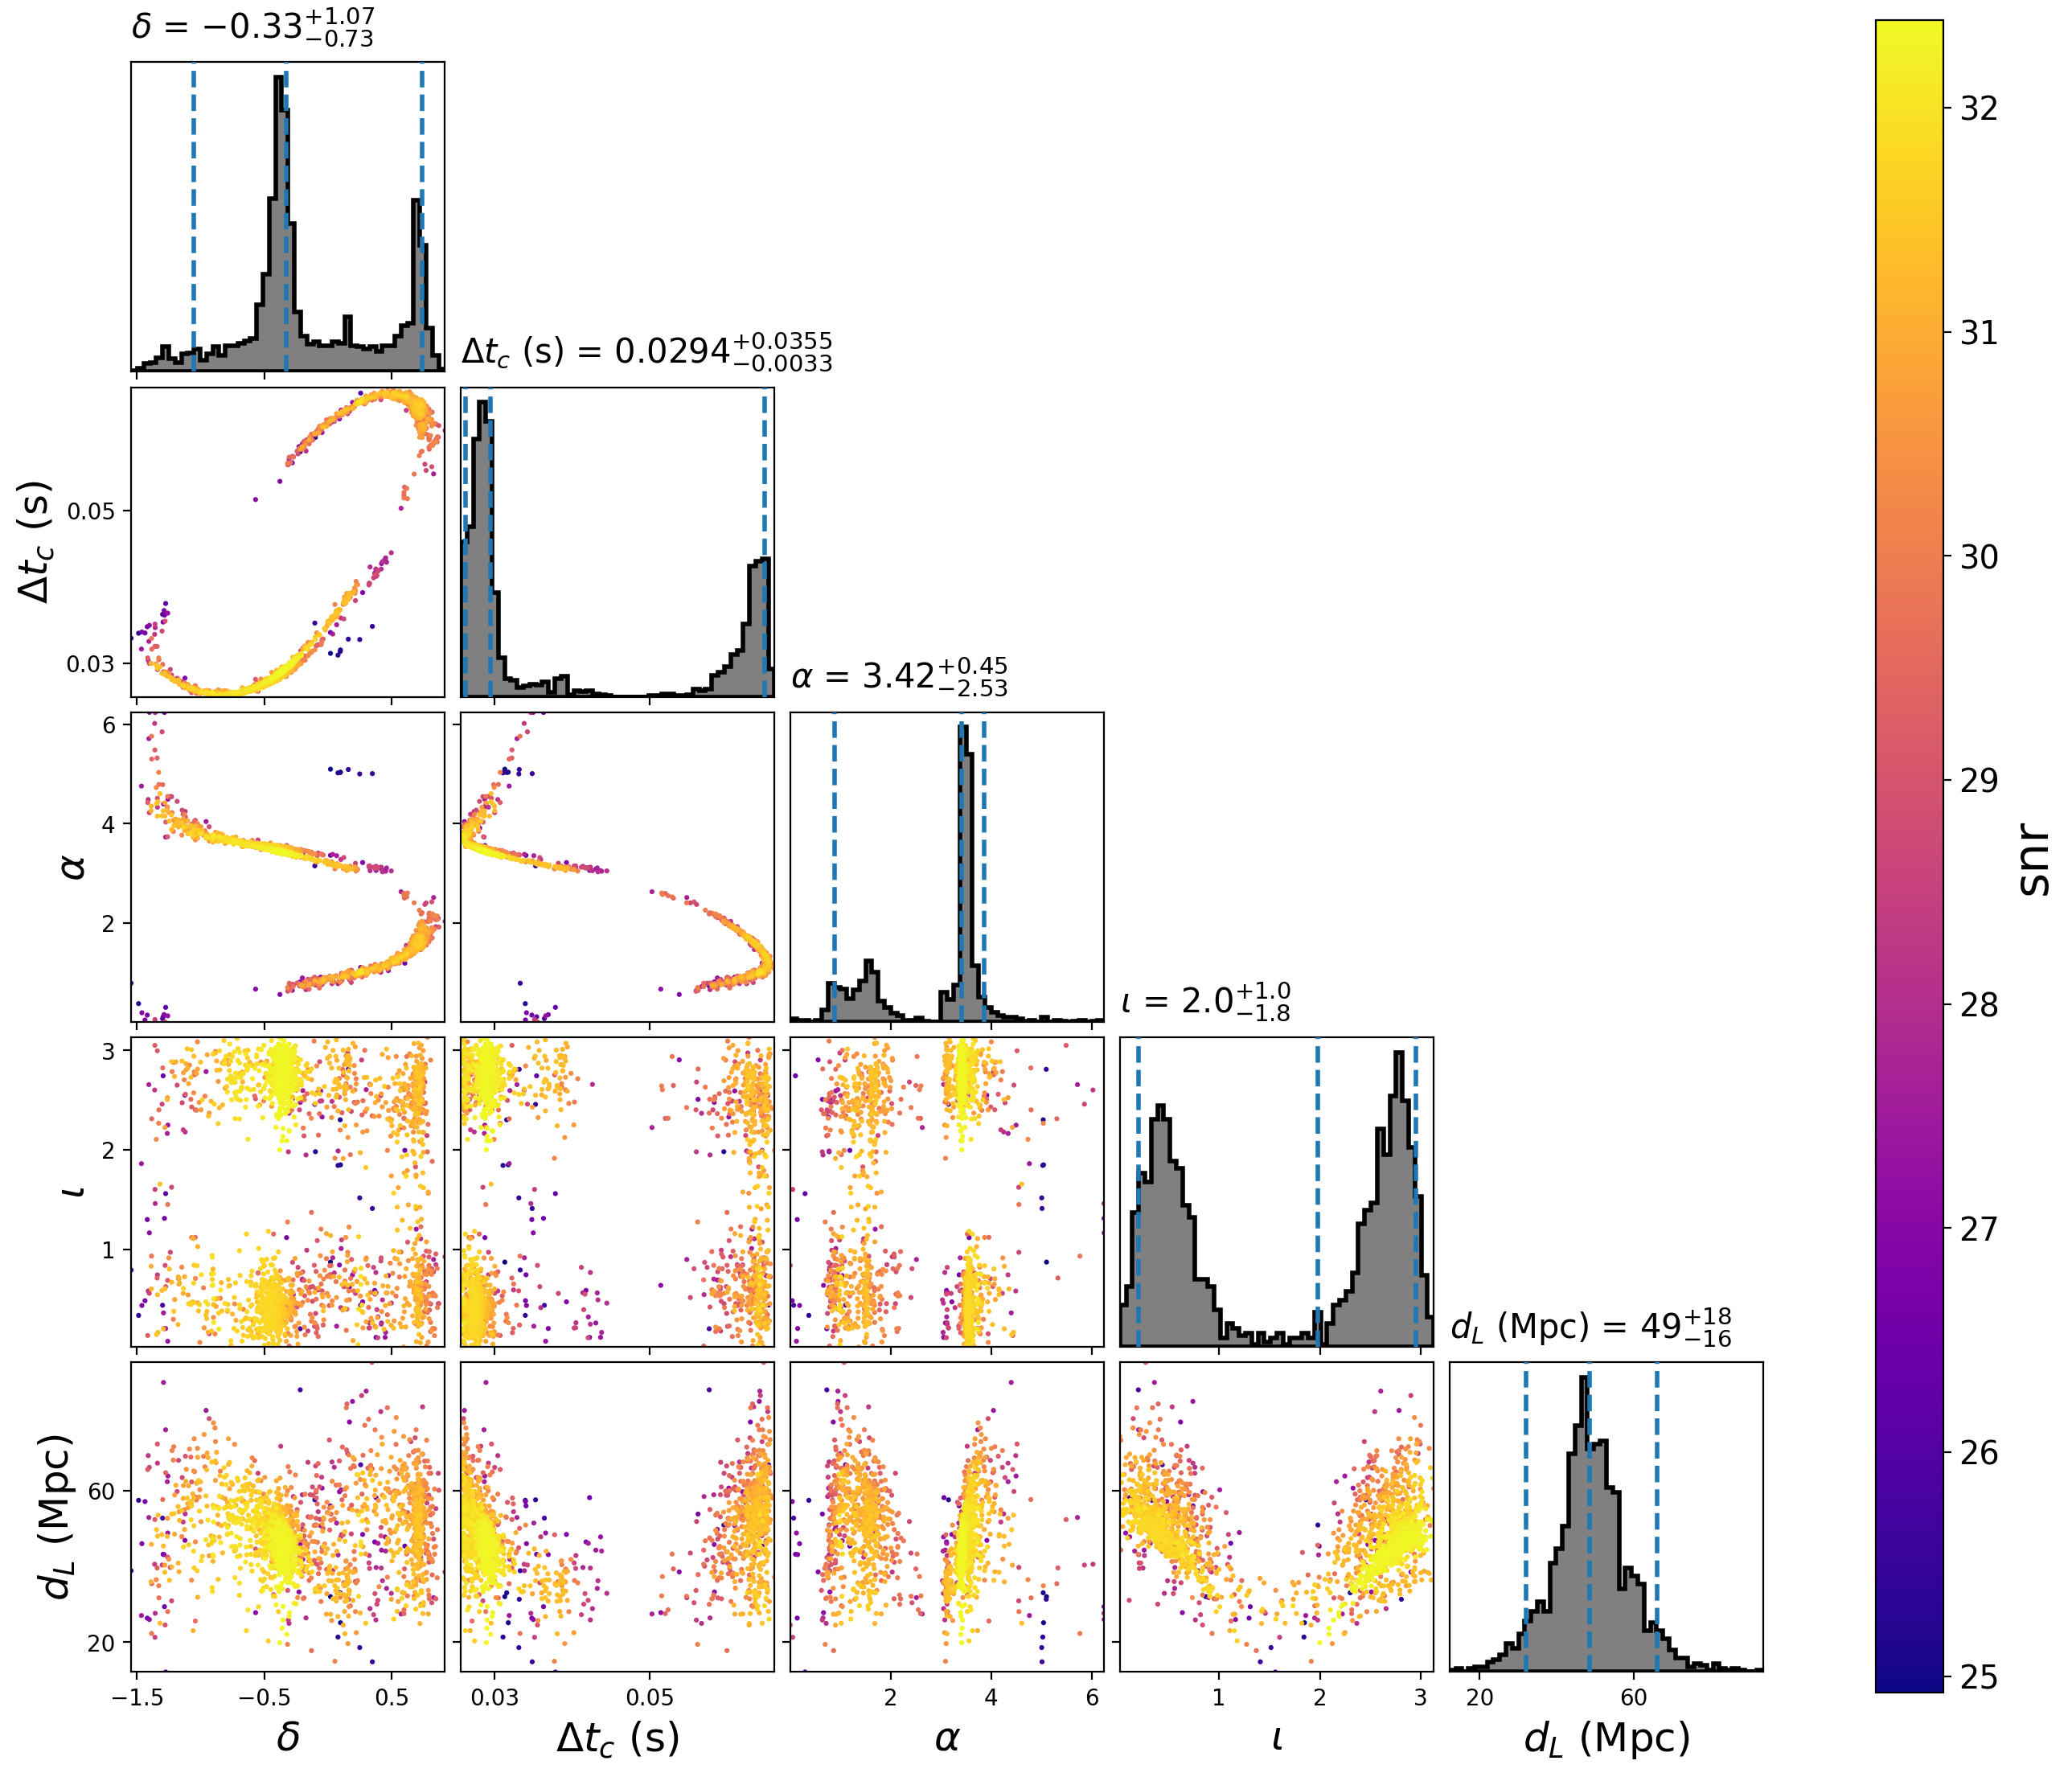

In [11]:
from IPython.display import Image
Image('posterior.png',height=560)

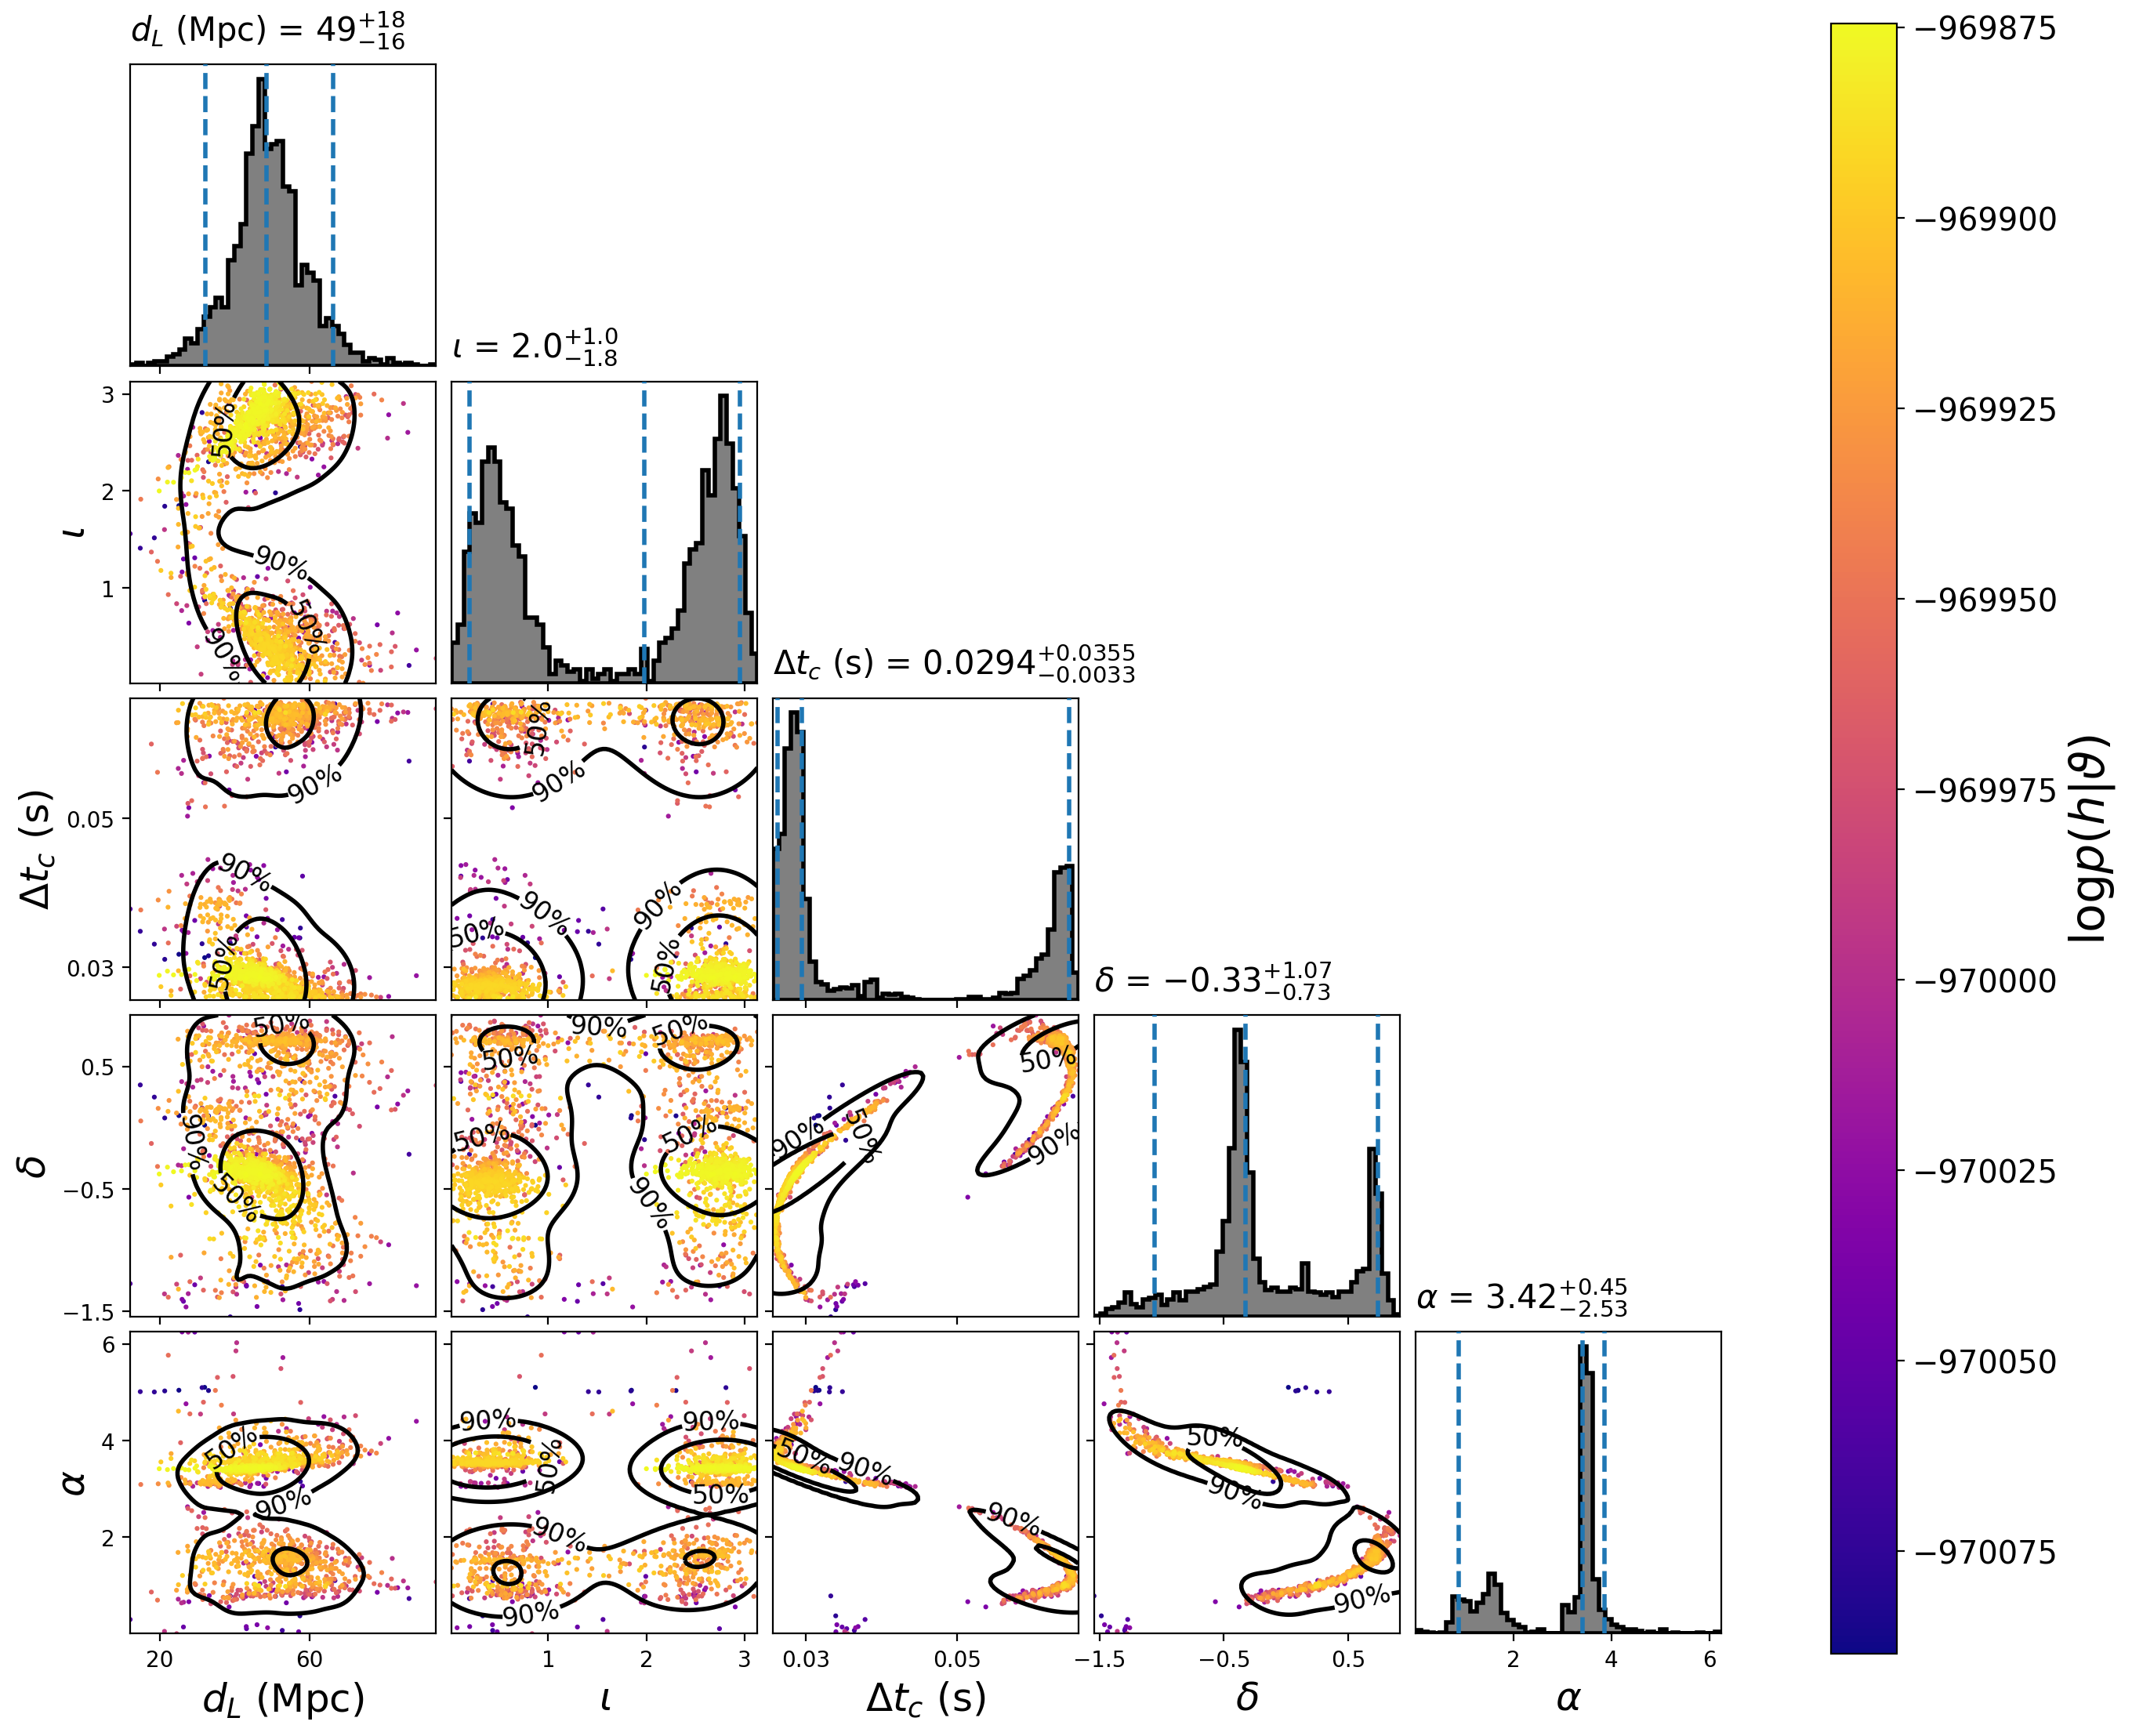

In [12]:
Image('posterior-normal2d.png',height=560)